In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
% autoreload 2

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')
import sys
sys.path.append('/users/amyskerry/documents/projects')
from pybq import bqdf, core, util
from pybq import credentialscfg as cred

In [5]:
bqdf.cfg.DEBUG

False

In [6]:
bqdf.cfg.FETCH_BY_DEFAULT

False

#Connect to a project

In [7]:
#connect to bigquery project via project_id
con = bqdf.Connection(project_id=cred.project_id, logging_file=cred.log)

In [10]:
tables=con.list_tables('lomulation', 'temp')

Tables list:
names
natality




In [11]:
for t in tables:
    if t not in ['names', 'natality']:
        con.delete_table('lomulation', 'temp', t)

In [12]:
#specify bq paths to tables
#format: project:dataset.tablename (if dataset is in current project_id, can use just dataset.tablename)
table1 = 'lomulation:temp.natality' 
table2 = 'lomulation:temp.names'

# Dataframe-ish abstraction for bigquery table

In [76]:
#create bqdf table connection
df1 = bqdf.BQDF(con, table1)
df2 = bqdf.BQDF(con, table2)

In [14]:
#these are not actually dataframes, but rather references to connected bigquery tables
#table referenced:
print df1.remote

lomulation:temp.natality


In [15]:
#we can access the connection object
print df1.con

In [16]:
#which is connected to project by bq api client
print df1.con.client

In [17]:
#a local copy or sample of the data is stored in df.local
#if FETCH_BY_DEFAULT is False, local contains only a copy of the first 5 rows (the table's "head")
df1.local

,source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,...,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
0,1969,1969,11,18,NaN,CA,True,1,10.74974,NaN,...,True,NaN,NaN,2,0,0,3,1,35,2
1,1970,1970,6,13,NaN,CA,True,1,10.74974,NaN,...,True,NaN,NaN,2,0,0,3,1,32,2
2,1970,1970,5,21,NaN,MI,True,1,10.74974,NaN,...,True,NaN,NaN,0,0,0,1,1,22,2
3,1970,1970,8,30,NaN,NJ,True,1,10.74974,NaN,...,True,NaN,NaN,3,55,55,4,1,48,2
4,1970,1970,1,23,NaN,OH,True,1,10.74974,NaN,...,True,NaN,NaN,1,0,0,2,1,27,2


##Basic access to table data

In [18]:
#standard dataframe.head()
df1.head()

,source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,...,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
0,1969,1969,11,18,NaN,CA,True,1,10.74974,NaN,...,True,NaN,NaN,2,0,0,3,1,35,2
1,1970,1970,6,13,NaN,CA,True,1,10.74974,NaN,...,True,NaN,NaN,2,0,0,3,1,32,2
2,1970,1970,5,21,NaN,MI,True,1,10.74974,NaN,...,True,NaN,NaN,0,0,0,1,1,22,2
3,1970,1970,8,30,NaN,NJ,True,1,10.74974,NaN,...,True,NaN,NaN,3,55,55,4,1,48,2
4,1970,1970,1,23,NaN,OH,True,1,10.74974,NaN,...,True,NaN,NaN,1,0,0,2,1,27,2


In [19]:
#can also view schema
schema=df2.table_schema()

state (STRING) :   mode-NULLABLE
gender (STRING) :   mode-NULLABLE
year (INTEGER) :   mode-NULLABLE
name (STRING) :   mode-NULLABLE
day (INTEGER) :   mode-NULLABLE


In [20]:
#get dataframe columns
df2.columns

[u'state', u'gender', u'year', u'name', u'day']

In [21]:
#get specific column values
df2['name'].values

array([u'Loretta', u'Tanya', u'Arlene', ..., u'Kristal', u'Josefina',
       u'Rhiannon'], dtype=object)

In [22]:
#unique values of month
df1['month'].unique()

array([11,  6,  5,  8,  1,  9,  2, 12,  4,  7, 10,  3])

In [23]:
#top most frequently occuring values in column
top=df1['month'].topk(3)
top.local

,month,count
0,8,11055
1,9,10928
2,10,10892


In [24]:
#shape of table
df1.size

(126059, 31)

In [55]:
df1.describe()

,alcohol_use,apgar_1min,apgar_5min,born_alive_alive,born_alive_dead,born_dead,child_race,cigarette_use,cigarettes_per_day,day,...,mother_age,mother_birth_state,mother_race,plurality,record_weight,source_year,wday,weight_gain_pounds,weight_pounds,year
count,0,0,0,4997.000000,4994.000000,4993.000000,5000.000000,0,0,5000.000000,...,5000.000000,0,5000.00000,0,5000,5000,0,0,4963.000000,5000
min,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.000000,...,13.000000,NaN,1.00000,NaN,2,1969,NaN,NaN,0.687842,1969
25th percentile,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,NaN,NaN,8.000000,...,20.000000,NaN,1.00000,NaN,2,1969,NaN,NaN,6.437498,1969
50th percentile,NaN,NaN,NaN,1.000000,0.000000,0.000000,1.000000,NaN,NaN,15.000000,...,23.000000,NaN,1.00000,NaN,2,1969,NaN,NaN,7.187070,1969
75th percentile,NaN,NaN,NaN,2.000000,0.000000,0.000000,1.000000,NaN,NaN,22.000000,...,27.000000,NaN,1.00000,NaN,2,1969,NaN,NaN,7.874912,1969
max,NaN,NaN,NaN,77.000000,77.000000,77.000000,9.000000,NaN,NaN,99.000000,...,48.000000,NaN,9.00000,NaN,2,1969,NaN,NaN,13.999354,1969
mean,NaN,NaN,NaN,1.780668,1.138366,1.258362,1.333200,NaN,NaN,15.615200,...,24.578600,NaN,1.32200,NaN,2,1969,NaN,NaN,7.192860,1969
std,NaN,NaN,NaN,5.773542,8.320288,8.462383,0.978146,NaN,NaN,8.918847,...,5.693356,NaN,0.96649,NaN,0,0,NaN,NaN,1.301148,0
mode,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,NaN,NaN,15.000000,...,21.000000,NaN,1.00000,NaN,2,1969,NaN,NaN,6.999677,1969


## Basic summary operations over columns

In [22]:
df1['weight_pounds'].mean()

8.1174901048650057

In [23]:
df1['weight_pounds'].std()

1.2628743825952706

In [24]:
df1['weight_pounds'].sem()

0.00097173454719847395

In [25]:
df1['weight_pounds'].max()

17.074802191899998

In [26]:
df1['weight_pounds'].min()

0.60847584312000003

In [27]:
df1['weight_pounds'].sum()

13710294.672295108

In [28]:
df1['month'].mode()

8

## Row-based operations

In [29]:
zscored=df1['weight_pounds'].zscore()
zscored.local

,zscore
0,0.748858
1,0.748858
2,2.134958
3,0.748858
4,0.748858


In [30]:
sqrt=df1['weight_pounds'].sqrt()
sqrt.local

,sqrt
0,3.010516
1,3.010516
2,3.288415
3,3.010516
4,3.010516


In [31]:
log = df1['weight_pounds'].log()
log.local

,log
0,2.204223
1,2.204223
2,2.380811
3,2.204223
4,2.204223


In [32]:
rounded = df1['weight_pounds'].round(dig=2)
rounded.local

,round
0,9.06
1,9.06
2,9.06
3,9.06
4,9.06


## Manipulating table data

In [33]:
df2.add_index(inplace=True)

In [34]:
df2.head()

,index,state,gender,year,name,day
0,1,ID,F,1946,Loretta,10
1,2,ID,F,1946,Tanya,8
2,3,ID,F,1946,Arlene,7
3,4,ID,F,1946,Harriet,5
4,5,ID,F,1947,Susan,142


In [35]:
del df2['index']

In [36]:
df2.head()

,state,gender,year,name,day
0,ID,F,1946,Loretta,10
1,ID,F,1946,Tanya,8
2,ID,F,1946,Arlene,7
3,ID,F,1946,Harriet,5
4,ID,F,1947,Susan,142


In [37]:
#return table with subset of columns
limited=df1[['day', 'year', 'state', 'is_male']]

In [38]:
#NOTE: this will inherit fetch status of the source (e.g. since df1.fetched=False, limited is not fetched locally)
len(limited.local)

126059

In [39]:
#but we can explicitly fetch the data
limited.fetch()

In [40]:
len(limited.local)

126059

In [77]:
df1.head()

,source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,...,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
0,1969,1969,5,26,NaN,AR,True,1,10.74974,NaN,...,True,NaN,NaN,1,0,0,2,1,26,2
1,1969,1969,5,5,NaN,MI,True,1,10.74974,NaN,...,True,NaN,NaN,6,0,0,7,1,31,2
2,1969,1969,1,2,NaN,MS,True,1,10.74974,NaN,...,True,NaN,NaN,0,0,0,1,1,21,2
3,1969,1969,2,5,NaN,NJ,True,1,10.74974,NaN,...,True,NaN,NaN,1,0,0,2,1,27,2
4,1969,1969,4,2,NaN,ND,True,1,10.74974,NaN,...,True,NaN,NaN,5,0,0,6,1,38,2


In [78]:
#add column with a specific value (could be useful for adding an intercept)
t=df1.add_col('test1', 100, inplace=False)

SELECT source_year, year, month, day, wday, state, is_male, child_race, weight_pounds, plurality, apgar_1min, apgar_5min, mother_residence_state, mother_race, mother_age, gestation_weeks, lmp, mother_married, mother_birth_state, cigarette_use, cigarettes_per_day, alcohol_use, drinks_per_week, weight_gain_pounds, born_alive_alive, born_alive_dead, born_dead, ever_born, father_race, father_age, record_weight, test1 FROM (SELECT ROW_NUMBER() OVER() as index, * FROM lomulation:temp.natality_newcol_8550) as tb1 JOIN(SELECT ROW_NUMBER() OVER() as index, * from [lomulation:temp.natality]) tb2 on tb1.index==tb2.index
2015-08-09 21:47:18.510000
Waiting on bqjob_rb02380a2aed3184_0000014f15ba1985_51 ... (3s) Current status: DONE   


In [ ]:
#add column with local list/array (of course must be able to fit single column in local RAM)
df1.add_col('test2', [np.random.randint(1000) for i in range(len(df1))])

In [ ]:
#add column with remote column of equal length (often transformation of another column in df)
df1.add_col('normalized_weight', df1['weight_pounds'].zscore())

In [ ]:
df1[['test1', 'test2', 'normalized_weight', 'weight_pounds']].head()

In [82]:
mini=limited.slice(2,120)

/users/amyskerry/documents/projects/pybq/bqdf.py:148: UserWarning: failed to write new slice to bigquery
  warnings.warn('failed to write new slice to bigquery')


In [83]:
mini.fetch()
mini.head()

,day,year,state,is_male
0,24,1978,VA,True
1,9,1976,NE,True
2,20,1976,TX,True
3,5,1982,MD,True
4,7,1971,MO,True


In [84]:
def get_gender(x):
    if x:
        return 'Male'
    else:
        return 'Female'
newmini=mini['is_male'].apply(get_gender)

/users/amyskerry/documents/projects/pybq/bqdf.py:219: UserWarning: remote writing of UDF apply function failed
  warnings.warn('remote writing of UDF apply function failed')


In [ ]:
mini.replace('is_male', mini['is_male'].apply(get_gender))

## Operations on pairs of columns

In [113]:
df1.dot('month', 'weight_pounds')

234266.48007965862

In [115]:
df1.cos('day', 'weight_pounds')

0.85775406307842916

In [116]:
df1.corr('month', 'weight_pounds')

0.039757234078351092

In [117]:
df1.euclidean('month', 'weight_pounds')

258.95662187561317

In [135]:
mat=df1.contingency_mat('month', 'day')
mat

Number of rows in remote table exceeds bqdf object's max_rows. Only max_rows have been fetched locally


day,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,99
month,,,,,,,,,,,,,,,,,,,,,
1,10,9,12,12,12,13,8,11,13,13,...,15,15,14,13,10,10,14,13,14,NaN
2,9,18,14,17,18,14,13,18,8,15,...,12,12,27,18,8,9,NaN,NaN,1,1
3,14,10,13,22,14,12,15,11,21,17,...,14,19,16,11,15,18,10,5,16,NaN
4,14,13,12,7,11,8,22,16,14,11,...,8,12,13,5,9,12,14,13,NaN,NaN
5,11,18,19,11,18,13,7,18,12,11,...,12,12,13,10,13,8,14,5,17,1
6,16,12,17,15,10,17,17,8,13,10,...,17,9,7,16,14,21,11,13,1,NaN
7,14,11,19,8,12,11,16,17,18,18,...,14,14,27,10,10,18,12,12,12,NaN
8,13,9,14,24,17,12,16,10,13,10,...,12,12,9,10,10,25,10,19,11,NaN
9,14,13,18,11,13,11,11,15,16,15,...,18,19,14,14,12,11,16,10,NaN,NaN


corrmat=df1.corr_mat()

## Joining and filtering

In [351]:
# df.where is used for filtering the table.
# each condition is expressed as it's own string argument
# only simple equality, greater than, less than are currently supported
print len(df1)
ndf = df1.where('day==4')
print len(ndf)
ndf = df1.where('weight_pounds>8', 'mother_age < 20', fetch=True)
print len(ndf.local)

1688982
Number of rows in remote table exceeds bqdf object's max_rows. Only max_rows have been fetched locally
16491
Number of rows in remote table exceeds bqdf object's max_rows. Only max_rows have been fetched locally
78890


In [354]:
print ndf['weight_pounds'].min()
print ndf['mother_age'].max()

8.02262171418
19


In [ ]:
#join two tables
#note this returns a new BQDF object with a reference to the resulting table
jdf=df1.join(df2, on='year', how='inner')

## More flexible querying

In [107]:
#execute arbitrary sql commands and return as df and source
#note: raw_query does not return a BQDF object
querystr = """
SELECT subr, num_comments, score, c_posts FROM %s  LIMIT 1000
""" %table1
df, source = bqdf.raw_query(con, querystr)

Waiting on bqjob_r32bde585b7276dcb_0000014e9c0e7d6c_328 ... (0s) Current status: DONE   


In [53]:
df1.query(querystr)

,subr,num_comments,score,c_posts
0,Winnipeg,23782,35017,1000
1,winterporn,1858,61256,1000
2,wisconsin,24893,71500,999
3,woahdude,126829,2089822,1000
4,women,12128,63478,1000


##Plotting

In [ ]:
#create a histogram of a column's values
histdf=df1['weight_pounds'].hist(bins=20)

In [ ]:
#create a simple plot (mean +/- 1 SEM) of value_col, broken down by grouping_col
value_col='weight_pounds'
grouping_col='month'
df1.plot(grouping_col, value_col, kind='bar')

Waiting on bqjob_r5446ea84859d2408_0000014e9c108526_339 ... (0s) Current status: DONE   
0.000267028808594
Waiting on bqjob_r254a7a18c87ae0a3_0000014e9c108822_340 ... (0s) Current status: DONE   
Waiting on bqjob_r13cbc6b92c94b718_0000014e9c108b40_341 ... (0s) Current status: DONE   
0.00558471679688
Waiting on bqjob_r470bd9571cb96a81_0000014e9c109321_342 ... (0s) Current status: DONE   
0.0102310180664
Waiting on bqjob_r70edbaee454db3dc_0000014e9c1099ca_343 ... (0s) Current status: DONE   
Waiting on bqjob_r68e0ea3c6440532a_0000014e9c10a133_344 ... (0s) Current status: DONE   
0.0151901245117


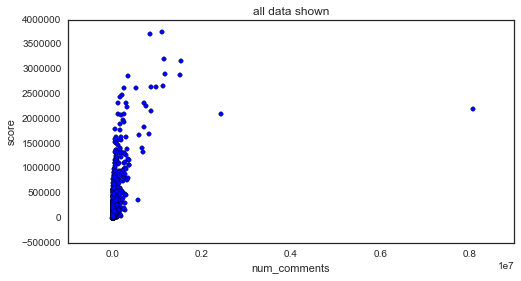

In [114]:
#create scatter plot of x vs. y (since bins > total number of datapoints, will plot all data)
scatterseries=df1.scatter('weight_pounds', 'day', bins=1000)

Waiting on bqjob_r57465fd7070b45b_0000014e9bfcca94_175 ... (0s) Current status: DONE   
Waiting on bqjob_r5c068c203eb4093c_0000014e9bfccd5a_176 ... (0s) Current status: DONE   
Waiting on bqjob_r8ffe5f69ef98ff9_0000014e9bfcd244_177 ... (0s) Current status: DONE   
Waiting on bqjob_r449e1df5c4378473_0000014e9bfcd989_178 ... (0s) Current status: DONE   
query saved to durable-footing-95814:_7f939837d73fe18145c1d220d8cea862f339ce2f.anon95ee7e5b5fafebb5e597a3541b0640d971cc0d93
returning head only
Waiting on bqjob_r185516469de6755b_0000014e9bfcdcb6_179 ... (0s) Current status: DONE   
Waiting on bqjob_r143c60795e77f250_0000014e9bfce3e6_180 ... (0s) Current status: DONE   
Waiting on bqjob_r2fa60537e947ca0c_0000014e9bfceb68_181 ... (0s) Current status: DONE   
query saved to durable-footing-95814:_7f939837d73fe18145c1d220d8cea862f339ce2f.anon58daa3ca68c9e2778f67288fe354a2d0260271f1
returning head only
Waiting on bqjob_r63168006009c68a8_0000014e9bfcedcc_182 ... (0s) Current status: DONE   
Wa

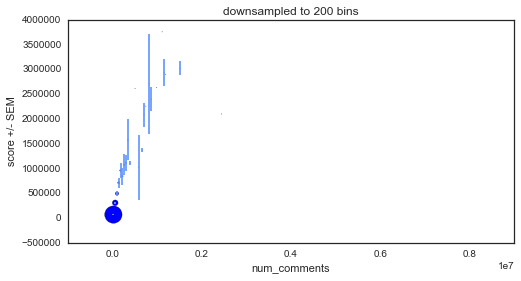

In [60]:
#create a downsampled scatter plot of x vs. y
plotdf=df1.scatter('weight_pounds', 'day', bins=200)